In [3]:
import numpy as np
import sys, os, glob
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.stats import ttest_ind, ttest_1samp, pearsonr, ranksums, zscore
from scipy.stats.mstats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
import statsmodels.api as sm
%matplotlib inline

code_path = '/Users/GA/Documents/Dayan_lab/Optimism_And_Pessimism_In_Optimised_Replay/Code/Task'
sys.path.append(code_path)
from misc_analysis import get_Q_true, get_optimal_move, permutation_test, get_entropy, get_joint_entropy, histogram, get_sorted_files

In [2]:
root_folder = '/Users/GA/Documents/Dayan_lab/Optimism_And_Pessimism_In_Optimised_Replay'

# Worlds & idcs
world1 = np.load(os.path.join(root_folder, 'Data/world1.npy'))
world2 = np.load(os.path.join(root_folder, 'Data/world2.npy'))
idcs1  = np.load(os.path.join(root_folder, 'Data/idcs1.npy'))
idcs2  = np.load(os.path.join(root_folder, 'Data/idcs2.npy'))

### Fitting errors

In [4]:
e = []
for i in range(40):
    df = pd.read_csv(os.path.join(root_folder, 'Data', 'new_new_fits', 'save_params_%u'%i, 'backup.txt'), header=None, sep='\t', index_col=False, skiprows=1)
    np.save(os.path.join(root_folder, 'Data', 'new_new_fits', 'save_params_%u'%i, 'params.npy'), df.iloc[-1].values[:18])
    e.append(df.iloc[-1].values[18])

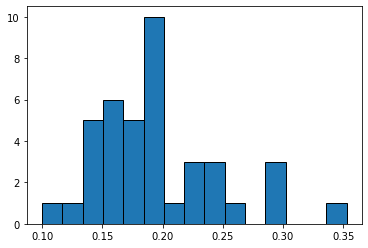

In [5]:
plt.hist(e, bins=15, edgecolor='k');
plt.savefig(os.path.join(root_folder, 'new_figures_data', 'supp9.svg'), transparent=True)
np.save(os.path.join(root_folder, 'new_figures_data', 'supp9', 'fit_errs.npy'), e)

### Get flexibility idcs for simulated data

In [11]:
def get_flex_idcs(sub):
    
    this_root_folder = os.path.join(root_folder, 'Data/tmp_flex/%u'%(sub))
    
    flex_idcs = []
    for rep in range(100):
    
        rep_folder  = os.path.join(this_root_folder, str(rep))

        opt_moves11 = 0
        opt_moves12 = 0
        opt_moves21 = 0
        opt_moves22 = 0

        # iterate over 5 blocks
        for i in range(5):
            if i == 0:
                this_range = 6
            else:
                this_range = 7
            tmp = []

            if i in [0, 1]:
                Q1_true, Q2_true = get_Q_true(world1, idcs1)
            elif i in [2, 3]:
                Q1_true, Q2_true = get_Q_true(world2, idcs1)
            else:
                Q1_true, Q2_true = get_Q_true(world2, idcs2)

            for j in range(this_range):

                moves = np.load(os.path.join(rep_folder, str(i), 'moves%u.npy'%j))

                for move in moves:

                    if len(move) != 2:
                        s = move[0]
                        a = move[1]
                        if a in get_optimal_move(s, Q2_true):
                            opt_moves11 += 1
                        elif a in get_optimal_move(s, Q1_true)//4:
                            opt_moves12 += 1

                    else:
                        s = move[0][0]
                        a = move[0][1]
                        if a in get_optimal_move(s, Q2_true):
                            opt_moves21 += 1
                        elif a in get_optimal_move(s, Q1_true)//4:
                            opt_moves22 += 1

        flex_idcs.append(opt_moves11/(18*5) - opt_moves12/(18*5) - opt_moves21/(36*5) + opt_moves22/(36*5))
    return flex_idcs

In [12]:
Y = np.zeros((100, 40))
for i in range(40):
    Y[:, i] = get_flex_idcs(i)
    print('Done %u'%i)
np.save(os.path.join(root_folder, 'Data/tmp_subject_data/all_flex.npy'), Y)

Done 0
Done 1
Done 2
Done 3
Done 4
Done 5
Done 6
Done 7
Done 8
Done 9
Done 10
Done 11
Done 12
Done 13
Done 14
Done 15
Done 16
Done 17
Done 18
Done 19
Done 20
Done 21
Done 22
Done 23
Done 24
Done 25
Done 26
Done 27
Done 28
Done 29
Done 30
Done 31
Done 32
Done 33
Done 34
Done 35
Done 36
Done 37
Done 38
Done 39


### Load flexibility idcs

In [6]:
flex_idcs_hums = np.zeros(40)
for i in range(40):
    tmp = np.load(os.path.join(root_folder, 'Data/subject_data/', str(i), 'flexibility.npy'))
    flex_idcs_hums[i] = tmp[0]-tmp[1]+tmp[3]-tmp[2]
    
path = os.path.join(root_folder, 'Data', 'subject_data', 'PerformanceSummaries.mat')
data = loadmat(path)

flex_idcs_hums = np.empty(0)
for i in range(40):
    tmp = np.mean(data['Fig1d'][i, :, :], axis=1)
    flex_idcs_hums = np.append(flex_idcs_hums, (tmp[0]-tmp[1]+tmp[3]-tmp[2]))

Y = np.load(os.path.join(root_folder, 'Data/tmp_subject_data/all_flex.npy'))
flex_idcs_ag   = np.mean(Y, axis=0)

In [7]:
subs_who_replay = np.load(os.path.join(root_folder, 'Data/tmp/Analysis', 'subs_who_replay.npy'))
vals = np.load(os.path.join(root_folder, 'Data/tmp/Analysis', 'policy_improve_value_objective.npy'))

### Regression human IF vs simulated IF

34
38


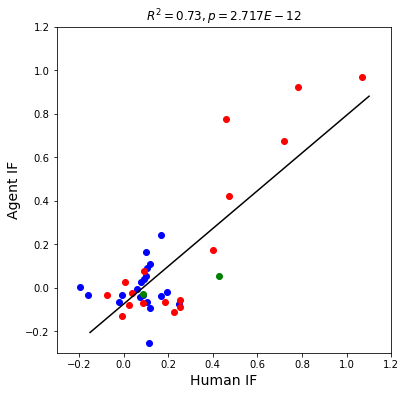

In [8]:
reg = LinearRegression().fit(flex_idcs_hums.reshape(-1, 1), np.array(flex_idcs_ag).reshape(-1,1))

x_pred = np.linspace(-0.15, 1.1, 20)
y_pred = reg.predict(x_pred.reshape(-1, 1))
rr, pr = pearsonr(flex_idcs_hums, flex_idcs_ag)

figure = plt.figure(figsize=(6, 6))

nb = np.zeros(40)
for i in range(40):
    if i in subs_who_replay:
        if i in subs_who_replay[np.argwhere(vals < 0).flatten()]:
            nb[i] = 2
            print(i)
        else:
            nb[i] = 1
            
plt.scatter(flex_idcs_hums[np.argwhere(nb == 0).flatten()], flex_idcs_ag[np.argwhere(nb == 0).flatten()], c='b')
plt.scatter(flex_idcs_hums[np.argwhere(nb == 1).flatten()], flex_idcs_ag[np.argwhere(nb == 1).flatten()], c='r')
plt.scatter(flex_idcs_hums[np.argwhere(nb == 2).flatten()], flex_idcs_ag[np.argwhere(nb == 2).flatten()], c='g')
            
plt.plot(x_pred, y_pred, c='k')
plt.ylim(-0.30,1.2)
plt.xlim(-0.30,1.2)
plt.xlabel('Human IF', fontsize=14)
plt.ylabel('Agent IF', fontsize=14)
plt.title(r'$R^{2}=%.2f, p=%.3E$'%(rr**2, pr));

flex_subs   = np.array([flex_idcs_ag[i] for i in subs_who_replay])
inflex_subs = np.array([flex_idcs_ag[i] for i in range(40) if i not in subs_who_replay])

# plt.savefig(os.path.join(root_folder, 'new_figures_data/supp3/a/plot.svg'), transparent=True)
# np.save(os.path.join(root_folder, 'new_figures_data/supp3/a/human_flex.npy'), flex_idcs_hums)
# np.save(os.path.join(root_folder, 'new_figures_data/supp3/a/agent_flex.npy'), flex_idcs_ag)
# np.save(os.path.join(root_folder, 'new_figures_data/supp3/a/sub_meta.npy'), nb)


# d, t, p = permutation_test(inflex_subs, flex_subs, 10000, return_tests=True)
# with open(os.path.join(root_folder, 'new_figures_data/supp3/a/stats.txt'), 'w') as f:
#     f.write('Regression: R^2 = %.3E, p = %.3E\n'%(rr**2, pr))
#     f.write('MF vs MI: t = %.3E, p = %.3E'%(t, p))
    
# with open(os.path.join(root_folder, 'new_figures_data/supp3/a/meta.txt'), 'w') as f:
#     f.write('File `sub_meta.npy` contains 40 entries for each subject.\n0 = MF subject; 1 = MI subject; 2 = MI subject who hurt himself')

(-0.3, 1.2)

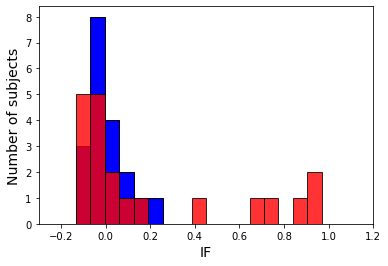

In [9]:
opt_h, opt_b, opt_w = histogram(flex_subs, bins=17, normalise=False)
subopt_h, subopt_b, _ = histogram(inflex_subs, bins=opt_b, normalise=False)
plt.bar(subopt_b, subopt_h, width=opt_w, facecolor='b', edgecolor='k', align='edge')
plt.bar(opt_b, opt_h, width=opt_w, facecolor='r', edgecolor='k', alpha=0.8, align='edge')
plt.xlabel('IF', fontsize=14)
plt.ylabel('Number of subjects', fontsize=14)
plt.xlim(-0.3, 1.2)

# permutation_test(inflex_subs, flex_subs, 10000)
# plt.savefig(os.path.join(root_folder, 'new_figures_data/supp3/a/hist.svg'), transparent=True)

# t, p = permutation_test(inflex_subs, flex_subs, 10000)
# with open(os.path.join(root_folder, 'new_figures_data/supp3/a/stats_hist.txt'), 'w') as f:
#     f.write('MF vs MI: t = %.3E, p = %.3E'%(t, p))

### Parameters IF analysis

In [10]:
params_path = os.path.join(root_folder, 'Data/new_new_fits')

In [11]:
for i in subs_who_replay:
    p = np.load(os.path.join(params_path, 'save_params_%u'%i, 'params.npy'))[:18]
    print('subject: %u, phi^{MB}: %.2f, phi^{MF}: %.2f'%(i, p[8], p[9]))

subject: 0, phi^{MB}: 0.99, phi^{MF}: 0.80
subject: 2, phi^{MB}: 1.00, phi^{MF}: 0.93
subject: 3, phi^{MB}: 1.00, phi^{MF}: 0.57
subject: 6, phi^{MB}: 0.45, phi^{MF}: 0.91
subject: 8, phi^{MB}: 1.00, phi^{MF}: 0.99
subject: 9, phi^{MB}: 0.79, phi^{MF}: 0.54
subject: 11, phi^{MB}: 0.94, phi^{MF}: 0.69
subject: 12, phi^{MB}: 0.15, phi^{MF}: 0.96
subject: 14, phi^{MB}: 0.95, phi^{MF}: 0.93
subject: 15, phi^{MB}: 0.19, phi^{MF}: 0.94
subject: 16, phi^{MB}: 0.95, phi^{MF}: 0.58
subject: 17, phi^{MB}: 0.84, phi^{MF}: 0.97
subject: 19, phi^{MB}: 1.00, phi^{MF}: 0.66
subject: 21, phi^{MB}: 1.00, phi^{MF}: 0.79
subject: 27, phi^{MB}: 0.12, phi^{MF}: 0.92
subject: 29, phi^{MB}: 0.87, phi^{MF}: 0.36
subject: 32, phi^{MB}: 1.00, phi^{MF}: 0.43
subject: 34, phi^{MB}: 0.15, phi^{MF}: 0.98
subject: 35, phi^{MB}: 0.92, phi^{MF}: 0.95
subject: 38, phi^{MB}: 0.15, phi^{MF}: 0.98


In [44]:
# subs = np.delete(range(40), subs_who_replay)
subs = subs_who_replay

# load params
MB_params = [5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17]
# MB_params = [5, 10, 11]

labels = np.delete(range(18), MB_params)

X = np.zeros((len(subs), 18))
for i in range(X.shape[0]):
    p = np.load(os.path.join(params_path, 'save_params_%u'%subs[i], 'params.npy'))[:18]
    p[8] = (1-p[8])
    p[9] = (1-p[9])
    X[i, :] = p

# zscore
X = zscore(X, axis=0)
y = zscore(np.mean(Y[:, subs], axis=0))

X = pd.DataFrame(X, columns=[str(i) for i in range(18)])
X.drop([str(i) for i in MB_params], axis=1, inplace=True)

estimator = LinearRegression()
selector  = RFECV(estimator, min_features_to_select=5, step=1, cv=5)
selector  = selector.fit(X, y)

for i in range(len(selector.ranking_)):
    if selector.ranking_[i] != 1:
        X.drop(str(labels[i]), axis=1, inplace=True)
        
est = sm.OLS(y, X)
est2 = est.fit()
print(est2.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.540
Model:                            OLS   Adj. R-squared (uncentered):              0.293
Method:                 Least Squares   F-statistic:                              2.183
Date:                Wed, 08 Sep 2021   Prob (F-statistic):                       0.106
Time:                        11:16:48   Log-Likelihood:                         -20.607
No. Observations:                  20   AIC:                                      55.21
Df Residuals:                      13   BIC:                                      62.18
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [39]:
coefs  = est2.params
labels = est2.params.index.astype(int)

sort_idcs  = np.argsort(np.abs(coefs))[::-1]

sorted_labels  = [labels[k] for k in sort_idcs]
sorted_coefs   = coefs[sort_idcs]
sorted_ci      = est2.conf_int(0.05).iloc[sort_idcs]

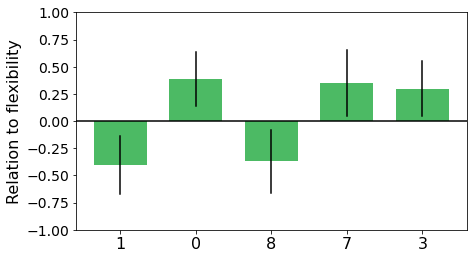

In [40]:
figure = plt.figure(figsize=(7, 4))

plt.bar(range(len(sorted_labels)), sorted_coefs, width=0.7, facecolor='#4CBA64')
for i in range(len(sorted_labels)):
    x = [i, i]
    y = [sorted_ci[0].iloc[i], sorted_ci[1].iloc[i]]
    plt.plot(x, y, c='k')
    
plt.axhline(0, c='k')
plt.xticks(range(len(sorted_labels)), sorted_labels, fontsize=16);
plt.yticks(fontsize=14)
plt.ylabel('Relation to flexibility', fontsize=16)
plt.ylim([-1.0, 1.0])

plt.savefig(os.path.join(root_folder, 'new_figures_data/supp3/b', 'MI_coef.svg'), transparent=True)
with open(os.path.join(root_folder, 'new_figures_data/supp3/b', 'stats_MI.txt'), 'w') as f:
    f.write(est2.summary().as_text())
est2.save(os.path.join(root_folder, 'new_figures_data/supp3/b/results_MI.pickle'))

### Replay is sometimes bad...

In [45]:
subs = subs_who_replay

# load params
MB_params = [5, 10, 11]
labels    = np.delete(range(18), MB_params)

X = np.zeros((len(subs), 18))
for i in range(X.shape[0]):
    p = np.load(os.path.join(params_path, 'save_params_%u'%subs[i], 'params.npy'))[:18]
    p[8] = (1-p[8])
    p[9] = (1-p[9])
    X[i, :] = p
    
# zscore
X = zscore(X, axis=0)
y = zscore(vals)

X = pd.DataFrame(X, columns=[str(i) for i in range(18)])
X.drop([str(i) for i in MB_params], axis=1, inplace=True)

estimator = LinearRegression()
selector  = RFECV(estimator, min_features_to_select=5, step=1, cv=5)
selector  = selector.fit(X, y)

for i in range(len(selector.ranking_)):
    if selector.ranking_[i] != 1:
        X.drop(str(labels[i]), axis=1, inplace=True)

est = sm.OLS(y, X)
est2 = est.fit()
print(est2.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.955
Model:                            OLS   Adj. R-squared (uncentered):              0.819
Method:                 Least Squares   F-statistic:                              7.018
Date:                Wed, 08 Sep 2021   Prob (F-statistic):                      0.0207
Time:                        11:17:00   Log-Likelihood:                          2.5565
No. Observations:                  20   AIC:                                      24.89
Df Residuals:                       5   BIC:                                      39.82
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [33]:
coefs  = est2.params
labels = est2.params.index.astype(int)

sort_idcs  = np.argsort(np.abs(coefs))[::-1]

sorted_labels  = [labels[k] for k in sort_idcs]
sorted_coefs   = coefs[sort_idcs]
sorted_ci      = est2.conf_int(0.05).iloc[sort_idcs]

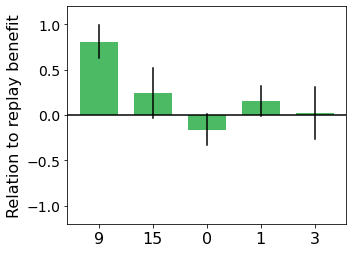

In [34]:
figure = plt.figure(figsize=(5, 4))

plt.bar(range(len(sorted_labels)), sorted_coefs, width=0.7, facecolor='#4CBA64')
for i in range(len(sorted_labels)):
    x = [i, i]
    y = [sorted_ci[0].iloc[i], sorted_ci[1].iloc[i]]
    plt.plot(x, y, c='k')
    
plt.axhline(0, c='k')
plt.xticks(range(len(sorted_labels)), sorted_labels, fontsize=16);
plt.yticks(fontsize=14)
plt.ylabel('Relation to replay benefit', fontsize=16)

plt.ylim([-1.2, 1.2])
plt.savefig(os.path.join(root_folder, 'new_figures_data/supp3/f', 'coef.svg'), transparent=True)
with open(os.path.join(root_folder, 'new_figures_data/supp3/f', 'stats_coef.txt'), 'w') as f:
    f.write(est2.summary().as_text())
est2.save(os.path.join(root_folder, 'new_figures_data/supp3/f/results_coef.pickle'))

### Parameters MF and MB

In [62]:
# load params
flex_tau, flex_rho, flex_xi   = [], [], []
inflex_tau, inflex_rho, inflex_xi = [], [], []

for i in range(40):
    p = np.load(os.path.join(params_path, 'save_params_%u'%i, 'params.npy'))[:18]
    if i in subs_who_replay:
        flex_tau.append(1-p[9])
        flex_rho.append(1-p[8])
        flex_xi.append(p[15])
    else:
        inflex_tau.append(1-p[9])
        inflex_rho.append(1-p[8])
        inflex_xi.append(p[15])

0.023028269999999962
0.02042301999999996


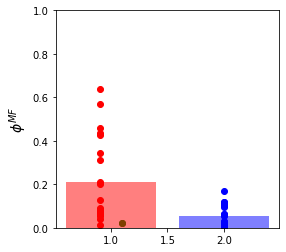

In [63]:
plt.figure(figsize=(4, 4))

plt.bar([1], np.mean(flex_tau), facecolor='r', alpha=0.5)
plt.bar([2], np.mean(inflex_tau), facecolor='b', alpha=0.5)
hurt = []
for i in range(len(flex_tau)):
    if vals[i] < 0:
        print(flex_tau[i])
        plt.scatter([1.1], flex_tau[i], facecolor='green')
    else:
        plt.scatter([0.9], flex_tau[i], facecolor='r')
plt.scatter([2]*len(inflex_tau), inflex_tau, color='b')
plt.ylabel(r'$\phi^{MF}$', fontsize=14)
plt.ylim(0, 1)

plt.savefig(os.path.join(root_folder, 'new_figures_data/supp3/c', 'phi_mf.svg'), transparent=True)
np.save(os.path.join(root_folder, 'new_figures_data/supp3/c', 'MI_phi_mf.npy'), flex_tau)
np.save(os.path.join(root_folder, 'new_figures_data/supp3/c', 'MF_phi_mf.npy'), inflex_tau)

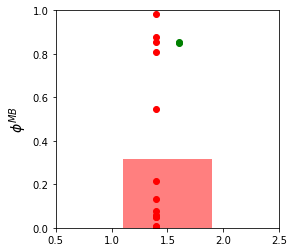

In [64]:
plt.figure(figsize=(4, 4))

hurt_rho    = []
benefit_rho = []
plt.bar([1.5], np.mean(flex_rho), facecolor='r', alpha=0.5)
for i in range(len(flex_rho)):
    if vals[i] < 0:
        hurt_rho.append(flex_rho[i])
        plt.scatter([1.6], flex_rho[i], c='green')
    else:
        benefit_rho.append(flex_rho[i])
        plt.scatter([1.4], flex_rho[i], c='r')
plt.ylabel(r'$\phi^{MB}$', fontsize=14)
plt.ylim(0, 1)
plt.xlim(0.5, 2.5)

plt.savefig(os.path.join(root_folder, 'new_figures_data/supp3/d', 'phi_mb.svg'), transparent=True)
np.save(os.path.join(root_folder, 'new_figures_data/supp3/d', 'MI_phi_mb.npy'), flex_rho)
np.save(os.path.join(root_folder, 'new_figures_data/supp3/d', 'MF_phi_mb.npy'), inflex_rho)

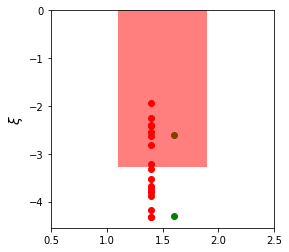

In [65]:
plt.figure(figsize=(4, 4))

hurt_xi    = []
benefit_xi = []
plt.bar([1.5], np.mean(np.log10(flex_xi)), alpha=0.5, facecolor='r')
for i in range(len(flex_xi)):
    if vals[i] < 0:
        hurt_xi.append(flex_xi[i])
        plt.scatter([1.6], np.log10(flex_xi[i]), c='green')
    else:
        benefit_xi.append(flex_xi[i])
        plt.scatter([1.4], np.log10(flex_xi[i]), c='r')
plt.xlim(0.5, 2.5)
plt.ylabel(r'$\xi$', fontsize=14)

plt.savefig(os.path.join(root_folder, 'new_figures_data/supp3/e', 'xi.svg'), transparent=True)
np.save(os.path.join(root_folder, 'new_figures_data/supp3/e', 'MI_xi.npy'), flex_xi)
np.save(os.path.join(root_folder, 'new_figures_data/supp3/e', 'MF_xi.npy'), inflex_xi)

In [66]:
t_tau, p_tau = ranksums(flex_tau, inflex_tau)
# tests_rho, t_rho, p_rho = bootstrap_test(np.array(hurt_rho), np.array(benefit_rho), 100000)
# tests_xi, t_xi,  p_xi  = bootstrap_test(np.array(hurt_xi), np.array(benefit_xi), 100000)
with open(os.path.join(root_folder, 'new_figures_data/supp3/c', 'stats.txt'), 'w') as f:
    f.write('Ranksums : MF phi vs MI phi   : t = %.3E, p = %.3E\n'%(t_tau, p_tau))
#     f.write('Bootstrap: Hurt rho   vs benefit rho: t = %.3E, p = %.3E\n'%(t_rho, p_rho))
#     f.write('Bootstrap: Hurt xi    vs benefit xi : t = %.3E, p = %.3E'%(t_xi, p_xi))

### Compare Eran's and our forgetting params

In [67]:
eran_params = os.path.join(root_folder, 'Data/subject_data/Parameter_fits.xls')
df_eran  = pd.read_excel(eran_params)
tau_eran = df_eran.iloc[7].values[1:]
rho_eran = df_eran.iloc[10].values[1:]

In [68]:
my_params = os.path.join(root_folder, 'Data/new_new_fits')
df_my = np.zeros((40, 18))
for i in range(df_my.shape[0]):
    p = np.load(os.path.join(my_params, 'save_params_%u'%i, 'params.npy'))[:18]
    df_my[i, :] = p
    
tau_my = (1-df_my[:, 8])
rho_my = (1-df_my[:, 9])

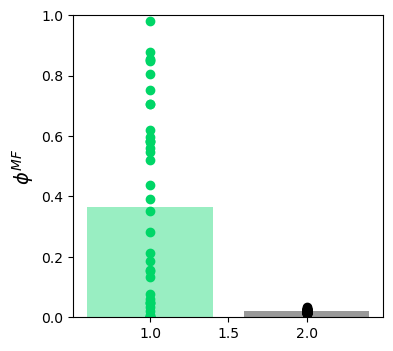

In [69]:
plt.figure(figsize=(4, 4), dpi=100)

plt.bar([1], np.mean(tau_my), facecolor='#00D667', alpha=0.4)
plt.scatter([1]*40, tau_my, c='#00D667')
plt.bar([2], np.mean(tau_eran), facecolor='k', alpha=0.4)
plt.scatter([2]*40, tau_eran, c='k')
plt.ylim(0, 1)
plt.ylabel(r'$\phi^{MF}$', fontsize=14)
t_tau, p_tau = ttest_ind(tau_my, tau_eran)

plt.savefig(os.path.join(root_folder, 'new_figures_data/supp2/a', 'phi_mf.svg'), transparent=True)
np.save(os.path.join(root_folder, 'new_figures_data/supp2/a', 'ours.npy'), tau_my)
np.save(os.path.join(root_folder, 'new_figures_data/supp2/a', 'erans.npy'), tau_eran)

with open(os.path.join(root_folder, 'new_figures_data/supp2/a', 'stats.txt'), 'w') as f:
    f.write('phi ours vs Eran\'s:      t = %.3E, p = %.3E\n'%(t_tau,  p_tau))

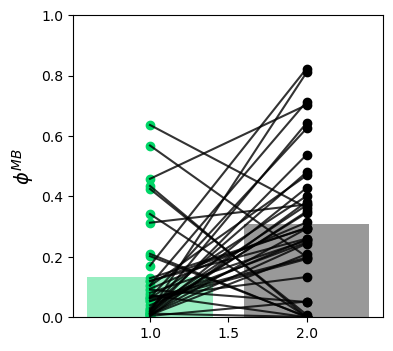

In [70]:
plt.figure(figsize=(4, 4), dpi=100)

plt.bar([1], np.mean(rho_my), facecolor='#00D667', alpha=0.4)
plt.scatter([1]*40, rho_my, c='#00D667')
plt.bar([2], np.mean(rho_eran), facecolor='k', alpha=0.4)
plt.scatter([2]*40, rho_eran, c='k')
for i in range(40):
    plt.plot([1, 2], [rho_my[i], rho_eran[i]], c='k', alpha=0.8)
plt.ylim(0, 1)
plt.ylabel(r'$\phi^{MB}$', fontsize=14)
t_rho, p_rho = ttest_ind(rho_my, rho_eran)

plt.savefig(os.path.join(root_folder, 'new_figures_data/supp2/b', 'phi_mb.svg'), transparent=True)
np.save(os.path.join(root_folder, 'new_figures_data/supp2/b', 'ours.npy'), rho_my)
np.save(os.path.join(root_folder, 'new_figures_data/supp2/b', 'erans.npy'), rho_eran)

with open(os.path.join(root_folder, 'new_figures_data/supp2/b', 'stats.txt'), 'w') as f:
    f.write('phi ours vs Eran\'s:      t = %.3E, p = %.3E\n'%(t_rho,  p_rho))

### Model entropy after training

In [71]:
task_folder = os.path.join(root_folder, 'Data/tmp/')

_, Q2_true  = get_Q_true(world1, idcs1)
ents_flex   = []
ents_inflex = []

for sub in range(40):
    sub_folder = os.path.join(task_folder, str(sub), 'training', '6')
    z = np.load(os.path.join(sub_folder, 'move47.npz'))
    T = z['T']
    tmp = []
    for s in range(8):
        a_opt = get_optimal_move(s, Q2_true)
        this_ent = get_entropy(T, s, a_opt)
        if len(this_ent) > 1:
            this_ent = np.mean(this_ent)
        else:
            this_ent = this_ent[0]
        tmp.append(this_ent)
    if sub in subs_who_replay:
        ents_flex += [np.mean(tmp)]
    else:
        ents_inflex += [np.mean(tmp)]

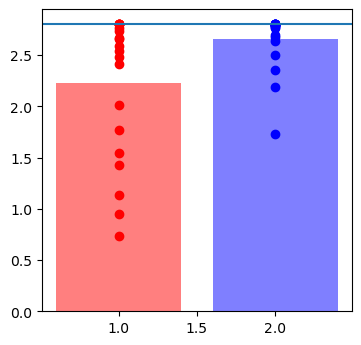

In [72]:
plt.figure(figsize=(4, 4), dpi=100)

plt.axhline(np.log2(7))

plt.bar(1, np.mean(ents_flex), facecolor='r', alpha=0.5)
plt.scatter([1]*len(ents_flex), ents_flex, c='r')
plt.bar(2, np.mean(ents_inflex), facecolor='b', alpha=0.5)
plt.scatter([2]*len(ents_inflex), ents_inflex, c='b')

t_diff, p_diff = ttest_ind(ents_flex, ents_inflex)

with open(os.path.join(root_folder, 'new_figures_data/supp8', 'stats.txt'), 'w') as f:
    f.write('ent MI vs ent MF: t = %.3E, p = %.3E\n'%(t_diff,  p_diff))

plt.savefig(os.path.join(root_folder, 'new_figures_data/supp8', 'model_entropy.svg'), transparent=True, format='svg')
np.save(os.path.join(root_folder, 'new_figures_data/supp8', 'MI_ent.npy'), ents_flex)
np.save(os.path.join(root_folder, 'new_figures_data/supp8', 'MF_ent.npy'), ents_inflex)

## Re-arranged Model 

In [64]:
task_folder   = os.path.join(root_folder, 'Data/tmp/')
params_folder = os.path.join(root_folder, 'Data/new_new_fits/')

subs_who_replay = np.load(os.path.join(task_folder, 'Analysis', 'subs_who_replay.npy'))

before = []
after  = []
ents   = []

_, Q2_true = get_Q_true(world2, idcs2)

for sub in subs_who_replay:
    
    sub_task_folder = os.path.join(task_folder, str(sub))
    
    rho = np.load(os.path.join(params_folder, 'save_params_%u'%sub, 'params.npy'))[12]
    
    # Model entropy before re-arrangement
    file = os.path.join(sub_task_folder, '3', '6', 'move11.npz')
    data = np.load(file, allow_pickle=True)
    T    = data['T']
    T    = rho*T + (1-rho)*(1./7)
    
    for i in range(T.shape[0]):
        for j in range(T.shape[1]):
            T[i, j, i]  = 0

            row = T[i, j, :]
            tmp = np.sum(row)
            if tmp > 0:
                T[i, j, :] = row / tmp
    
    # optimal action entropy without rearrangement
    tmp = 0
    for s in range(8):
        for a in range(4):
            tmp += np.power(Q2_true[s, a]-np.sum(T[s, a, :]*world2.ravel()), 2)
    before.append(tmp/32)

    tmp = []
    for s in range(8):
        a_opt = get_optimal_move(s, Q2_true)
        this_ent = get_entropy(T, s, a_opt)
        if len(this_ent) > 1:
            this_ent = np.mean(this_ent)
        else:
            this_ent = this_ent[0]
        tmp.append(this_ent)
    ents.append(np.mean(tmp))
    
    file = os.path.join(sub_task_folder, '3', 'offline.npz')
    data = np.load(file, allow_pickle=True)
    T    = data['T']
    
    # optimal action entropy with rearrangement
    tmp = 0
    for s in range(8):
        for a in range(4):
            tmp += np.power(Q2_true[s, a]-np.sum(T[s, a, :]*world2.ravel()), 2)
    after.append(tmp/32)

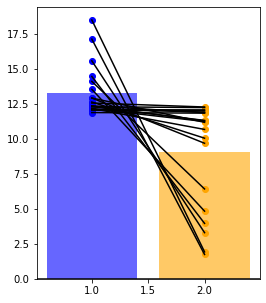

In [65]:
plt.figure(figsize=(4, 5))

plt.bar(2, np.mean(after), facecolor='orange', alpha=0.6, align='center')
plt.scatter([2]*len(after), after, c='orange')
plt.bar(1, np.mean(before), facecolor='b', alpha=0.6, align='center')
plt.scatter([1]*len(before), before, c='b')
plt.axhline(0, c='k')
for i in range(len(after)):
    plt.plot([2, 1], [after[i], before[i]], c='k')


t, p = ttest_ind(after, before)

# plt.savefig(os.path.join(root_folder, 'new_figures_data/supp6/a', 'rmsd_rearrangement.svg'), transparent=True, format='svg')
# np.save(os.path.join(root_folder, 'new_figures_data/supp6/a', 'after.npy'), after)
# np.save(os.path.join(root_folder, 'new_figures_data/supp6/a', 'before.npy'), before)
# with open(os.path.join(root_folder, 'new_figures_data/supp6/a', 'stats.txt'), 'w') as f:
#     f.write('after vs before: t=%.3E, p=%.3E'%(t, p))


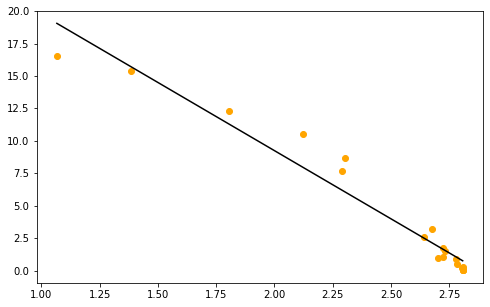

In [66]:
plt.figure(figsize=(8, 5))

diff = np.array(before) - np.array(after)

x = np.array(ents).reshape(-1, 1)
y = np.array(diff).reshape(-1, 1)

reg    = LinearRegression().fit(x, y)

x_pred = np.linspace(np.min(ents), np.max(ents), 50).reshape(-1, 1)
y_pred = reg.predict(x_pred)
plt.scatter(ents, diff, c='orange')
plt.plot(x_pred, y_pred, c='k')

r, p   = pearsonr(ents, diff)

# plt.savefig(os.path.join(root_folder, 'new_figures_data/supp6/b', 'rmsd_corr.svg'), transparent=True, format='svg')
# np.save(os.path.join(root_folder, 'new_figures_data/supp6/b', 'rmsd_diff.npy'), diff)
# np.save(os.path.join(root_folder, 'new_figures_data/supp6/b', 'entropies.npy'), ents)
# with open(os.path.join(root_folder, 'new_figures_data/supp6/b', 'stats.txt'), 'w') as f:
#     f.write('R^2 = %.3E, p = %.3E'%(r**2, p))

# plt.savefig(os.path.join(root_folder, 'new_figures_data/supp6/b/rmsd_corr.svg'), transparent=True)

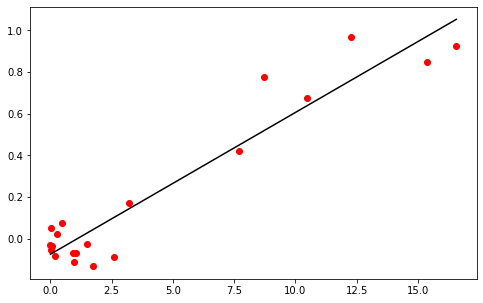

In [67]:
plt.figure(figsize=(8, 5))

reg    = LinearRegression().fit(np.array(diff).reshape(-1, 1), np.array(flex_subs))
r, p   = pearsonr(diff, flex_subs)
plt.scatter(diff, flex_subs, c='r')

x_pred = np.linspace(np.min(diff), np.max(diff), 50).reshape(-1, 1)
y_pred = reg.predict(x_pred)
plt.plot(x_pred, y_pred, c='k')

# plt.savefig(os.path.join(root_folder, 'new_figures_data/supp6/c', 'rmsd_corr_flex.svg'), transparent=True, format='svg')
# np.save(os.path.join(root_folder, 'new_figures_data/supp6/c', 'rmsd_diff.npy'), diff)
# np.save(os.path.join(root_folder, 'new_figures_data/supp6/c', 'MI_flex.npy'), flex_subs)
# with open(os.path.join(root_folder, 'new_figures_data/supp6/c', 'stats.txt'), 'w') as f:
#     f.write('R^2 = %.3E, p = %.3E'%(r**2, p))

# plt.savefig(os.path.join(root_folder, 'new_figures_data/supp6/c/rmsd_corr_if.svg'), transparent=True)

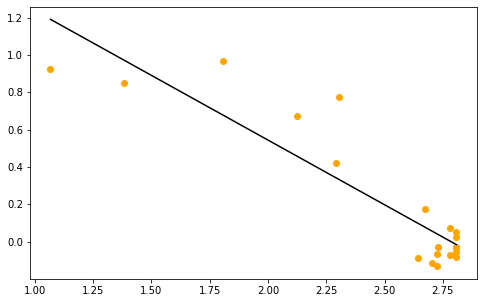

In [73]:
plt.figure(figsize=(8, 5))

x = np.array(ents).reshape(-1, 1)
y = np.mean(Y[:, subs_who_replay], axis=0).reshape(-1, 1)

reg    = LinearRegression().fit(x, y)

x_pred = np.linspace(np.min(x), np.max(x), 50).reshape(-1, 1)
y_pred = reg.predict(x_pred)
plt.scatter(x, y, c='orange')
plt.plot(x_pred, y_pred, c='k')

r, p   = pearsonr(x.flatten(), y.flatten())

plt.savefig(os.path.join(root_folder, 'new_figures_data/supp3/', 'ent_flex.svg'), transparent=True, format='svg')
with open(os.path.join(root_folder, 'new_figures_data/supp3/', 'stats_ent_flex.txt'), 'w') as f:
    f.write('R^2 = %.3E, p = %.3E'%(r**2, p))

plt.savefig(os.path.join(root_folder, 'new_figures_data/supp3/ent_flex.svg'), transparent=True)